# (i) Modelo com dois planetas circumbinários

Neste modelo de ajuste do ($O-C$) de Kepler-451, a fim de investigar as possíveis causas de sua VPO, usamos o método *MCMC* adaptado para o *Stretch Move* para ajustar os valores dos parâmetros livres da seguinte equação:

$$T_{min} = T_0 + EP + \sum_{1}^{N}\tau_j ,$$

sendo $T_{min}$ os instantes dos eclipses ajustados para uma efeméride linear do período orbital da binária, $P$, mais uma efeméride do ETL originado pela influência de um j-ésimo PCB sobre o sistema. O centro de massa da binária, $CM_2$, passa a orbitar em torno do centro de massa comum, que consiste na binária interna e no j-ésimo
planeta, $CM_j$.

Antes de tudo, importando as bibliotecas necessárias para esse ajuste, binando os dados para as barras de erro e definindo algumas constantes relevantes para essa metodologia:

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import smplotlib
from astropy import table
from astropy.io import ascii
from numba import jit
from scipy import optimize
from IPython.display import display, Math
import emcee
import corner

In [2]:
def adaptative_bin(x, y, yerr, oc, nbins):
    
    bins = np.array_split(x, nbins)

    xbin    = np.array([np.median(bin) for bin in bins])
    ybin    = np.array([np.median(y[np.in1d(x, bin)]) for bin in bins])
    yerrbin = np.array([np.std(yerr[np.in1d(x, bin)]) for bin in bins])
    ocbin   = np.array([np.median(oc[np.in1d(x, bin)]) for bin in bins])

    return xbin, ybin, yerrbin, ocbin

In [3]:
# According https://aas.org/posts/story/2013/08/report-2012-iau-xxviii-general-assembly
c = 299792458             # [m/s]
UA = 149597870700         # [m]

# According https://www.iau.org/static/resolutions/IAU2015_English.pdf 
G = 6.67408*10**(-11)     # 2014 CODATA 6.67408 (± 0.00031) × 10^(−11) m^3/(kg s^2)
G_gauss = (2*np.pi)**2       # [year, AU, M_Sun] 
M_Sun = 1.9891*10**(30)   # [kg]
M_Jup = 1.89813*10**(27)  # [kg]

# Binary's masses according to Østensen et al. (2010):
M_1 = 0.48                # [M_Sun]
erro_M1 = 0.03
M_2 = 0.12                # [M_Sun]
erro_M2 = 0.01

Agora vamos importar os dados fotométricos coletados desse sistema entre os anos de 2008 a 2024. O arquivo `2008_2024.txt` possui os ciclos, instantes dos eclipses em *BJD*-2450000 e os erros dos instantes ajustados pelo modelo WD+PIKAIA.

Esse arquivo contém observações de 2008 realizadas pelo Prof. Dr. Leonardo Andrade de Almeida, os dados obtidos pela missão *Kepler* de 2009 a 2013 com uma cadência de 60 s (Q0,5–17) e os dados obtidos pelo *TESS* de 2019 a 2024 dos setores 14 e 15 com cadência de 120 s e os setores 40, 54, 74 e 75 com cadência de 20 s.

Os instantes dos eclipses em *BKJD* e *BTJD*, baixados pela função [`search_lightcurve()`](https://iopscience.iop.org/article/10.3847/1538-3881/aafc33/meta) da biblioteca [`lightkurve`](https://ui.adsabs.harvard.edu/abs/2018ascl.soft12013L/abstract) do `python` e ajustados por nós pelo método WD+PIKAIA, foram convertidos para *BJD*-2450000 através de uma ferramenta `cl` do *IRAF*, obedecendo a sequinte relação:

$\begin{cases}
    BJD = BKJD + 2454833\\
    BJD = BTJD + 2457000
\end{cases}$

In [4]:
data = ascii.read('2008_2024.dat')

x    = data['cycle']
y    = data['time']
yerr = data['time_err']

data[:5]

<Table length=5>
 cycle      time    time_err
float64   float64   float64 
------- ----------- --------
-2486.0   4640.8642    4e-05
-1891.0   4715.6944    4e-05
-1772.0   4730.6606    4e-05
-1557.0   4757.7001    4e-05
    2.0 4953.768147    9e-06

Em nosso modelo de análise da VPO de Kepler-451, usamos a equação das efemérides linear, referente aos instantes dos eclipses calculados pelo modelo WD+PIKAIA, mais do ETL a cima para ajustar dois sinais senoidais no ($O-C$). Os $\tau_3$ e $\tau_4$, ocasionados pelos terceiro e quarto corpos (PCBs), são determinados como:

$$\tau_j = \frac{a_j\sin i_j}{c}\left[\frac{1-e^2_j}{1+e_j\cos\nu_j}\sin\left(\nu_j + \overline{\omega}_j\right)+e_j\sin\overline{\omega}_j\right] ,$$

onde a anomalia verdadeira, $\nu_j$, é derivada pelas seguintes relações:

1.  $\tan\left(\frac{\nu_j}{2}\right) = \sqrt{\frac{1+e_j}{1-e_j}}\tan\left(\frac{\epsilon_j}{2}\right)$

2.  $\epsilon_j - e_j\sin\epsilon_j = \mathcal{M_j}$ (eq. transcendente da anomalia excêntrica)

3.  $\epsilon_j \sim \mathcal{M_j} + \left(e_j - \frac{3}{24}e^2_j\right)\sin(\mathcal{M_j}) + \left(\frac{e^2_j}{2}-\frac{e^4_j}{8}\right)\sin(2\mathcal{M_j}) \ldots$ (solução da eq. transcendente)

4.  $\mathcal{M_j} = \frac{2\pi}{P'_j}(T_0 + EP - T'_j)$ (anomalia média)

Usamos como parâmetros de entrada para a função `optimize.curve_fit()` da biblioteca [`scipy`](https://zenodo.org/records/6940349), função que nos fornece os valores iniciais dos parâmetros para o *MCMC Stretch Move*, o período orbital e a inclinação¹ da binária encontrados por [Baran et al.](https://www.aanda.org/articles/aa/abs/2015/05/aa25392-14/aa25392-14.html) e aproximadamente 400 e 4000 dias para os períodos orbitais do terceiro e quarto corpos, respectivamente. 

¹Assumimos que os PCBs são coplanares à binária.

In [5]:
@jit(nopython=True)
def model_2bodys (x, P, T0, P3, T3, e3, asini3, o3, P4, T4, e4, asini4, o4):
    
    n_points = len(x)

    efli = np.zeros(n_points)     
    tau3 = np.zeros(n_points)
    tau4 = np.zeros(n_points)

    r3   = 360./P3                   # movimento angular médio do terceiro corpo externo
    r4   = 360./P4                   # movimento angular médio do quarto corpo externo

    for idx in range(n_points):
        n = x[idx]
        
        # Efeméride linear
        el = T0 + P*n
        efli[idx] = el
        
        # Primeiro corpo externo
        M  = ((T0 + P*n) - T3)*r3    # anomalia média do terceiro corpo
        M1 = M -(360*int(M/360.))    # M[0°,360°]
        M2 = M1 * np.pi / 180.
        eps = M2 + e3*np.sin(M2)     # solução da eq. transcendente da anomalia excêntrica com excentricidade até 1° ordem
        eps1 = eps + (M2 - (eps - e3*np.sin(eps)))/(1.0 - e3*np.cos(eps))
        for i in range(10):
            eps1 = eps1 + (M2 - (eps1 - e3*np.sin(eps1)))/(1.0 - e3*np.cos(eps1))
        q  = np.sqrt((1.0 + e3) / (1.0 - e3)) * np.tan(eps1 / 2.0)
        v  = 2. * np.arctan(q)       # anomalia verdadeira
        aux1  = asini3*UA / (c*24*3600)
        aux2  = ((1. - e3**2) / (1 + e3*np.cos(v))) * np.sin(v + ((o3%360)*np.pi/180.))
        aux3  = e3*np.sin((o3%360)*np.pi/180.)
        mody  = aux1 * (aux2 + aux3)
        tau3[idx] = mody
        
        # Segundo corpo externo
        M  = ((T0 + P*n) - T4)*r4    # anomalia média do quarto corpo
        M1 = M -(360*int(M/360.))    
        M2 = M1 * np.pi / 180.
        eps = M2 + e4*np.sin(M2)     
        eps1 = eps + (M2 - (eps - e4*np.sin(eps)))/(1.0 - e4*np.cos(eps))
        for i in range(10):
            eps1 = eps1 + (M2 - (eps1 - e4*np.sin(eps1)))/(1.0 - e4*np.cos(eps1))
        q  = np.sqrt((1.0 + e4) / (1.0 - e4)) * np.tan(eps1 / 2.0)
        v  = 2. * np.arctan(q)       
        aux1  = asini4*UA / (c*24*3600)
        aux2  = ((1. - e4**2) / (1 + e4*np.cos(v))) * np.sin(v + ((o4%360)*np.pi/180.))
        aux3  = e4*np.sin((o4%360)*np.pi/180.)
        mody  = aux1 * (aux2 + aux3)
        tau4[idx] = mody

    Tmin = efli + tau3 + tau4 
    return Tmin


p0 = [0.125765282, 4953.516,
      404, 1243, 0.16, 1.34278*np.sin(69.45*np.pi/180), 140,
      4200, 1243, 0.40, 7.98635*np.sin(69.45*np.pi/180), 270]

bounds = [(0.1250, 4900,
           300, 1000, 0.0, 0., 0, 0,
           1000, 1000, 0.0, 0. , 0., 0.),
          (0.1260, 5000,
           np.inf, 2000, 0.99, 10., 360, 360,
           np.inf, 2000, 0.99, 10., 360, 360)]

params2_, cov2_ = optimize.curve_fit(model_2bodys, x, y, sigma=yerr, p0 = p0, maxfev=5000)
params2_

array([1.25765285e-01, 4.95351666e+03, 3.88623792e+02, 1.44545909e+03,
       1.06413391e-01, 2.28197611e-03, 9.47694413e+01, 4.77923051e+03,
       1.07564904e+03, 7.19437088e-01, 6.93497305e-03, 2.46081527e+02])

Usamos o Teorema de Bayes,

$$\mathbb{P}(\boldsymbol{\theta}|\mathbf{D}) = \frac{\mathbb{P}(\mathbf{D}|\boldsymbol{\theta})\mathbb{P}(\boldsymbol{\theta})}{\mathbb{P}(\mathbf{D})}$$ \\
$$ln\mathbb{P}(\boldsymbol{\theta}|\mathbf{D}) = ln\mathbb{P}(\mathbf{D}|\boldsymbol{\theta}) + ln\mathbb{P}(\boldsymbol{\theta}) - ln\mathbb{P}(\mathbf{D}) ,$$

para definir a distribuição a posteriori dos parâmetros $\theta$ do modelo com $D$ dados, $\mathbb{P}(\boldsymbol{\theta}|\mathbf{D})$. Na prática, $ln\mathbb{P}(\mathbf{D})$ não afeta o processo de optimização dos parâmetros, logo podemos simplificar a posteriori como sendo proporcional à verossimilhança, $\mathbb{P}(\mathbf{D}|\boldsymbol{\theta})$, e à distribuição a priori, $\mathbb{P}(\boldsymbol{\theta})$:

$$ln\mathbb{P}(\boldsymbol{\theta}|\mathbf{D}) \propto ln\mathbb{P}(\mathbf{D}|\boldsymbol{\theta}) + ln\mathbb{P}(\boldsymbol{\theta})$$

E o logaritmo da verossimilhança na forma:

$$ln\mathbb{P}(\mathbf{D}|\boldsymbol{\theta}) = -\frac{1}{2}\sum_{1}^{N}\left(\frac{(O_j - C_j)^2}{\sigma^2_j} + ln(2\pi\sigma^2_j)\right)$$

In [6]:
@jit(nopython=True)
def lnlike_model2(theta, x, y, yerr):
    P, T0, P3, T3, e3, asini3, o3, P4, T4, e4, asini4, o4 = theta
    model = model_2bodys(x, P, T0, P3, T3, e3, asini3, o3, P4, T4, e4, asini4, o4)
    lnlike = np.sum(((y - model)/yerr)**2 + np.log(2*np.pi*yerr**2))
    if np.isnan(lnlike) or np.isinf(lnlike):
        return -np.inf
    return -0.5 * lnlike    


@jit(nopython=True)
def lnprior_model2(theta):
    P, T0, P3, T3, e3, asini3, o3, P4, T4, e4, asini4, o4 = theta
    if (0.1257 < P < 0.1258 and 4953.51 < T0 < 4953.53 and
        300 < P3 < 500 and 1400 < T3 < 2000 and 0.0 <= e3 < 0.99 and 0 < asini3 < 5 and 90 < o3 < 420 and
        3000 < P4 < 6000 and 1000 < T4 < 2000 and 0.0 <= e4 < 0.99 and 0 < asini4 < 5 and 0 < o4 <= 360):
        return 0.0
    return -np.inf


@jit(nopython=True)
def lnpos_model2(theta, x, y, yerr):
    lnprior = lnprior_model2(theta)
    if not np.isfinite(lnprior):
        return -np.inf
    return lnprior + lnlike_model2(theta, x, y, yerr)     

Definindo os parâmetros iniciais para o *MCMC* como os obtidos pelo `optimize`:

In [7]:
params2_

array([1.25765285e-01, 4.95351666e+03, 3.88623792e+02, 1.44545909e+03,
       1.06413391e-01, 2.28197611e-03, 9.47694413e+01, 4.77923051e+03,
       1.07564904e+03, 7.19437088e-01, 6.93497305e-03, 2.46081527e+02])

In [8]:
Pi      = 1.25765285e-01
T0i     = 4.95351666e+03
P3i     = 3.88623792e+02
T3i     = 1.44545909e+03
e3i     = 1.06413391e-01
asini3i = 2.28197611e-03
o3i     = 9.47694413e+01
P4i     = 4.77923051e+03
T4i     = 1.07564904e+03
e4i     = 7.19437088e-01
asini4i = 6.93497305e-03
o4i     = 2.46081527e+02

initial = np.array([])
initial = Pi, T0i, P3i, T3i, e3i, asini3i, o3i, P4i, T4i, e4i, asini4i, o4i

Definindo o número de *walkers*, responsáveis pela exploração do espaço de parâmetros, e o tamanho do seu passo (*jump*):

In [9]:
pos1 = np.array([])
pos2 = np.array([])
jump = [1e-5 for i in range(len(initial))]   #jump
for i in range(4*len(initial)):              #walkers
    for j in range(len(jump)):
        pos = initial[j] + jump[j] * np.random.randn(1)
        pos1 = np.append(pos1, pos)

pos2 = np.concatenate((pos2, pos1))
pos3 = np.reshape(pos2, (-1, len(initial)))

labels = ['P', 'T0', 'P3', 'T3', 'e3', 'asini3', 'o3', 'P4', 'T4', 'e4', 'asini4', 'o4']
print('+--------------------------------------+')
print('                 Ranges')
print('+--------------------------------------+')
for i in range(len(labels)):
    print(labels[i]+' = (%.8f, %.8f)'%(min(pos3[:,i]), max(pos3[:,i])))

+--------------------------------------+
                 Ranges
+--------------------------------------+
P = (0.12574303, 0.12578711)
T0 = (4953.51664554, 4953.51668798)
P3 = (388.62376649, 388.62380965)
T3 = (1445.45906873, 1445.45910562)
e3 = (0.10638563, 0.10643577)
asini3 = (0.00225227, 0.00230916)
o3 = (94.76942068, 94.76947521)
P4 = (4779.23049095, 4779.23053000)
T4 = (1075.64902493, 1075.64905648)
e4 = (0.71941104, 0.71945274)
asini4 = (0.00691730, 0.00695980)
o4 = (246.08150688, 246.08155359)


Implementando a variação *Stretch Move* do *MCMC* por meio da biblioteca [`emcee`](https://iopscience.iop.org/article/10.1086/670067/meta) do `python`:

In [10]:
nwalkers, ndim = pos3.shape

sampler = emcee.EnsembleSampler(nwalkers, ndim, lnpos_model2, args=(x, y, yerr))
sampler.run_mcmc(pos3, 5000, progress=True);  # número de passos para cada walker = 5000
samples = sampler.chain[:, :, :].reshape((-1, ndim))
ndim

100%|██████████| 5000/5000 [42:15<00:00,  1.97it/s] 


12

Plotando as distribuições a posterioris dos parâmetros ajustados (*trace-plot*):

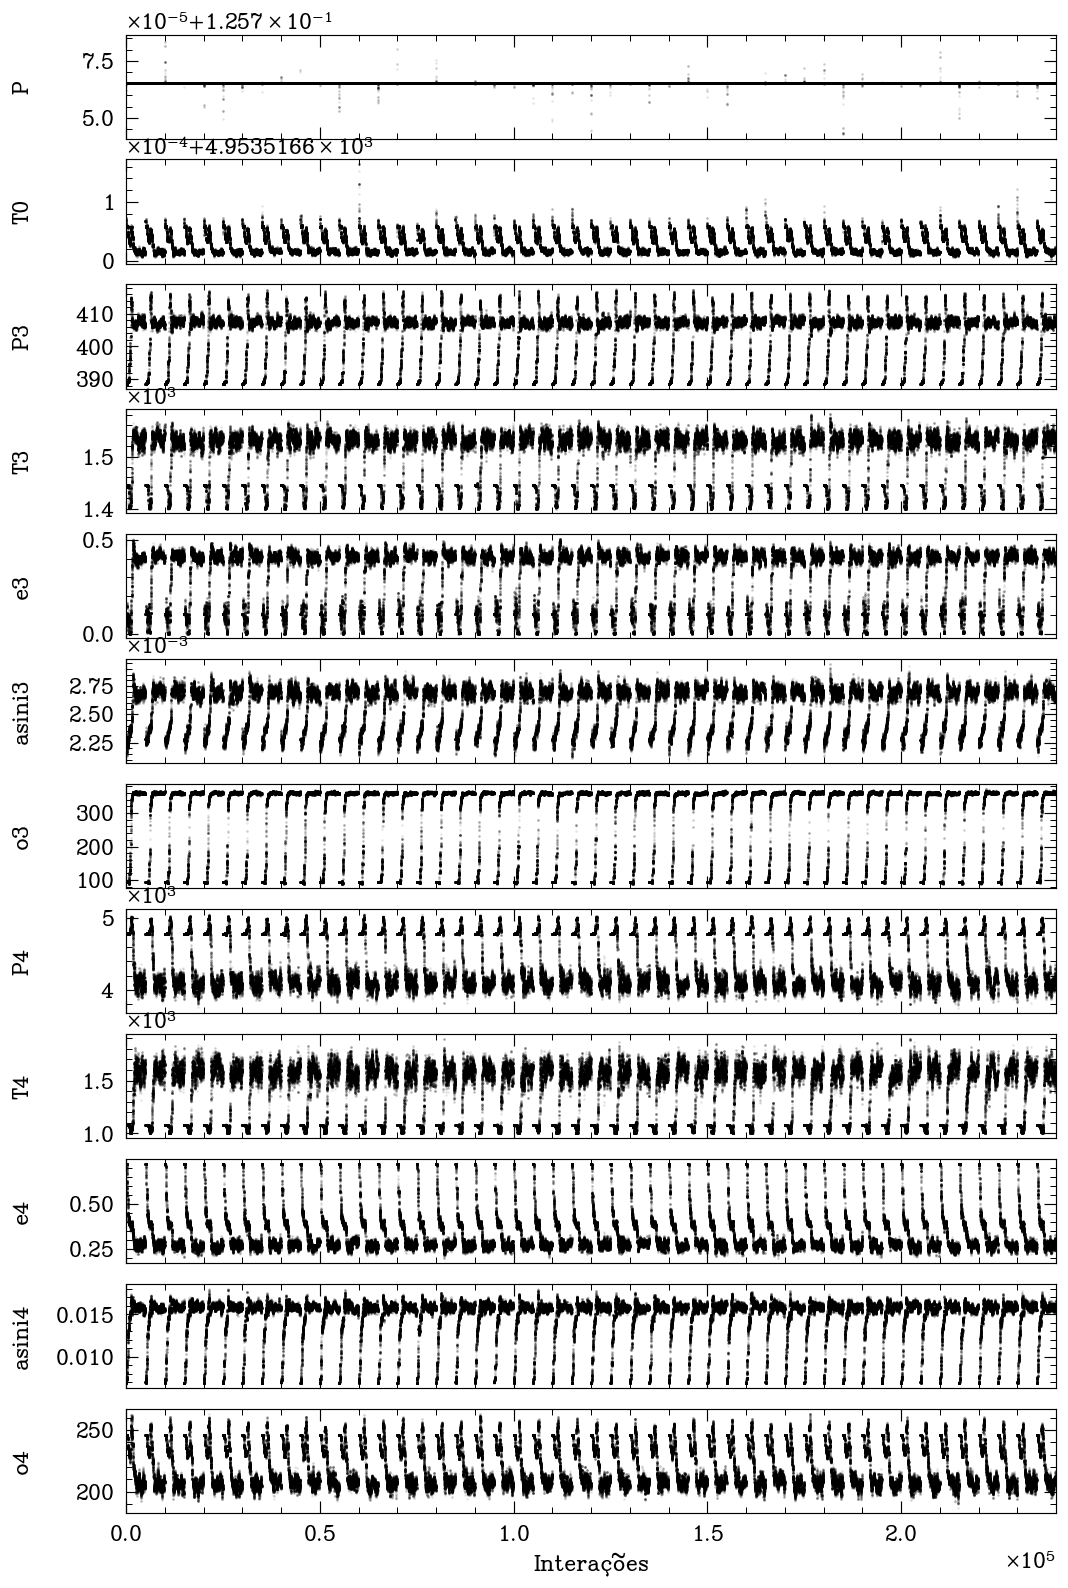

In [23]:
fig, axes = plt.subplots(ndim, figsize=(10, 16), sharex=True)
samples = sampler.chain[:, :, :].reshape((-1, ndim))
labels = ['P', 'T0', 'P3', 'T3', 'e3', 'asini3', 'o3', 'P4', 'T4', 'e4', 'asini4', 'o4']

for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, i,], ".k", alpha=0.1, ms=1)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)
axes[-1].set_xlabel("Interações");
#fig.savefig("aposteriori_2bodys.png")

Para sistemas com dois e três planetas, é necessário um *burn-in* de pelo menos algumas centenas:

In [12]:
flat_samples2 = sampler.get_chain(discard=2000, flat=True)

Calculando a taxa de aceitação média deste ajuste e os percentis (16%, 50% e 84%) de amostras da cadeia *MCMC* para cada parâmetro do modelo:

In [24]:
acceptance_fractions = sampler.acceptance_fraction
avg_acceptance_fraction = np.mean(acceptance_fractions)

print("Número total de propostas pós-burn-in:", len(flat_samples2))
print("Número de propostas aceitas pós-burn-in:", avg_acceptance_fraction * len(flat_samples2))
print("Taxa de aceitação média:", avg_acceptance_fraction)

Número total de propostas pós-burn-in: 144000
Número de propostas aceitas pós-burn-in: 55471.200000000004
Taxa de aceitação média: 0.3852166666666667


In [25]:
results2 = np.array([])
erroinf2 = np.array([])
errosup2 = np.array([])
for i in range(ndim):
    mcmc = np.percentile(flat_samples2[:, i], [16, 50, 84])
    q    = np.diff(mcmc)
    results2 = np.append(results2, mcmc[1])
    erroinf2 = np.append(erroinf2, q[0])
    errosup2 = np.append(errosup2, q[1])
    txt = "\mathrm{{{3}}} = {0:.4f}_{{-{1:.4f}}}^{{{2:.4f}}}"
    txt = txt.format(mcmc[1], q[0], q[1], labels[i])
    display(Math(txt))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

Plotando do Diagrama Corner dos parâmetros ajustados:

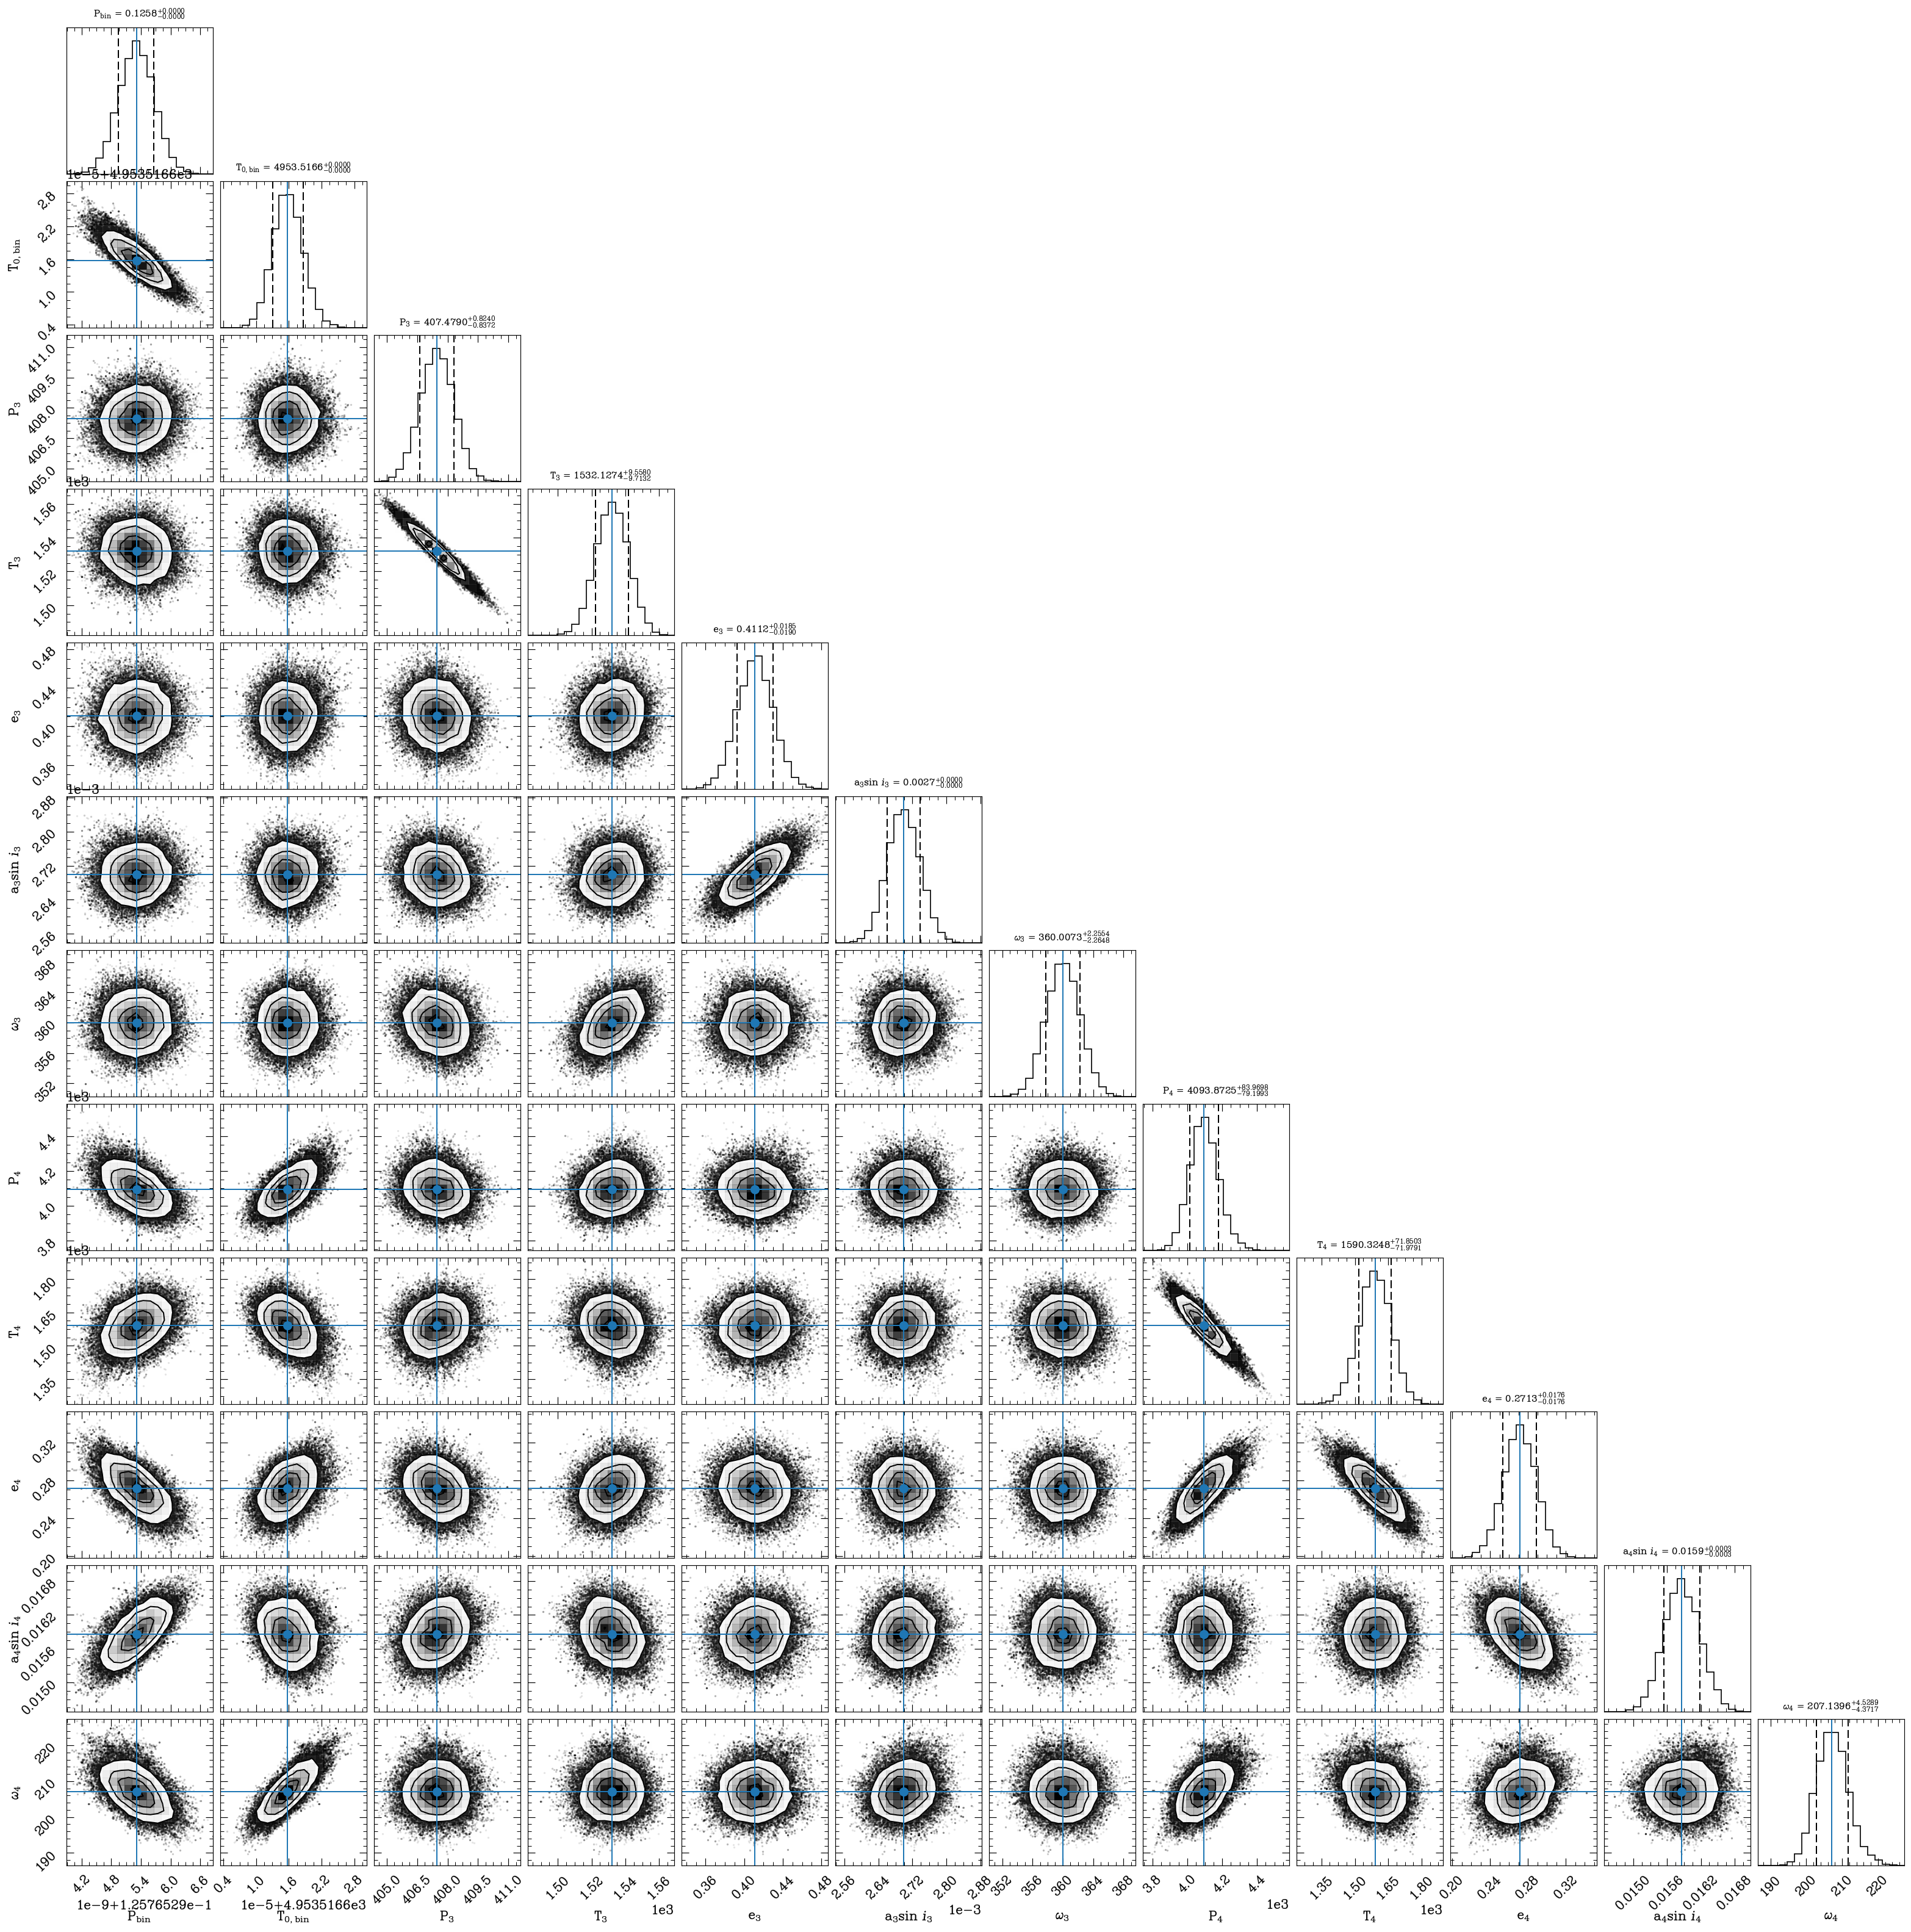

In [26]:
labels1 = [r'$\rm P_{bin}$', r'$\rm T_{0,bin}$', 
          r'$\rm P_{3}$', r'$\rm T_{3}$', r'$\mathrm{e}_{3}$', r'$\mathrm{a}_{3} \sin \, i_{3}$', r'$\omega_{3}$', 
          r'$\rm P_{4}$', r'$\rm T_{4}$', r'$\mathrm{e}_{4}$', r'$\mathrm{a}_{4} \sin \, i_{4}$', r'$\omega_{4}$']

value1 = results2
value2 = []
value3 = []


fig = corner.corner(flat_samples2, labels=labels1)


axes = np.array(fig.axes).reshape((ndim, ndim))
for i, label in enumerate(labels1):
    ax = axes[i,i]
    
    # Maximum Probability and interval
    ax.axvline(results2[i], color="tab:blue", linestyle="-")
    ax.axvline(results2[i] - erroinf2[i], color='k', ls='--')
    ax.axvline(results2[i] + errosup2[i], color='k', ls='--')
    ax.set_title(r'{0} = '.format(label)+ r'%.4f$^{+ %.4f}_{- %.4f}$'%(results2[i], errosup2[i], erroinf2[i]), fontsize=11)

    
    
for yi in range(ndim):
    for xi in range(yi):
        ax = axes[yi, xi]
        ax.axvline(value1[xi], color='tab:blue', ls='-')
        ax.axhline(value1[yi], color='tab:blue', ls='-')
        ax.plot(value1[xi], value1[yi], color="tab:blue", marker='o')


#plt.savefig('model_2bodys_corner.png')

Salvando os ajustes em uma tabela e definindo a média$\pm$incerteza dos resultados:

In [27]:
tbl2 = table.Table()
tbl2['parametros'] = np.array(labels)
tbl2['valor']      = np.array(results2)
tbl2['erro_inf']   = erroinf2
tbl2['erro_sup']   = errosup2


ascii.write(tbl2, 'model_2bodys.dat', overwrite=True)
tbl2

<Table length=12>
parametros         valor                erro_inf               erro_sup       
   str6           float64               float64                float64        
---------- --------------------- ---------------------- ----------------------
         P   0.12576529530807778   3.63949398396457e-10 3.5547573218330797e-10
        T0      4953.51661578594  2.679193130461499e-06 2.8461681722546928e-06
        P3    407.47899296127724     0.8372416361727346     0.8240185599438519
        T3    1532.1273772208765      9.713158869124754      9.558040434129225
        e3    0.4112426177609797    0.01895142983351583    0.01851073114747842
    asini3 0.0026986011693368576  3.761117396357434e-05 3.9451035969295493e-05
        o3      360.007298467488      2.264832821604614      2.255389138590772
        P4    4093.8724680746886      79.19925175073377      83.96982766676729
        T4     1590.324803762278      71.97909278228781      71.85029433862564
        e4    0.2712606223175453   0.017607677465687088   0.017640896126777272
    asini4    0.0158592836395885 0.00031502989493856215  0.0003284711730353225
        o4    207.13958953940215      4.371659895577949      4.528917851960102

In [28]:
#Determinando média +/- incerteza:

data = ascii.read('model_2bodys.dat')
m = data['valor']
erro_inf = data['erro_inf']
erro_sup = data['erro_sup']

labels = ['P', 'T0', 'P3', 'T3', 'e3', 'asini3', 'o3', 'P4', 'T4', 'e4', 'asini4', 'o4']
print('+--------------------------------------+')
print('                 Ranges')
print('+--------------------------------------+')
for i in range(len(m)):
    m1 = m[i]
    erro = (erro_inf[i] + erro_sup[i])/2
    print(f'{labels[i]} = {m1} +/- {erro:.10e}')

+--------------------------------------+
                 Ranges
+--------------------------------------+
P = 0.12576529530807778 +/- 3.5971256529e-10
T0 = 4953.51661578594 +/- 2.7626806514e-06
P3 = 407.47899296127724 +/- 8.3063009806e-01
T3 = 1532.1273772208765 +/- 9.6355996516e+00
e3 = 0.4112426177609797 +/- 1.8731080490e-02
asini3 = 0.0026986011693368576 +/- 3.8531104966e-05
o3 = 360.007298467488 +/- 2.2601109801e+00
P4 = 4093.8724680746886 +/- 8.1584539709e+01
T4 = 1590.324803762278 +/- 7.1914693560e+01
e4 = 0.2712606223175453 +/- 1.7624286796e-02
asini4 = 0.0158592836395885 +/- 3.2175053399e-04
o4 = 207.13958953940215 +/- 4.4502888738e+00


Calculando o chi-quadrado reduzido, $\chi^2_{red}$, para medir a qualidade deste ajuste:

$$\chi^2_{red} = \frac{1}{N-M}\sum^{N}_{1}\left(\frac{O_j - C_j}{\sigma_j}\right)^2$$

In [29]:
# Definindo a função para calcular chi-quadrado reduzido:
def reduced_chi2_2bodys(x, y, yerr, params):
    N = len(x)
    M = len(params)
    model = model_2bodys(x, *params)
    chi2 = (1/(N-M)) * np.sum(((y - model)/yerr)**2)
    return chi2

# Calculando o chi-quadrado reduzido
params_2bodys = ascii.read('model_2bodys.dat')['valor']
print('Chi-quadrado reduzido do modelo para dois PCBs: ', reduced_chi2_2bodys(x, y, yerr, params_2bodys))

Chi-quadrado reduzido do modelo para dois PCBs:  11.90241581416065


Fazendo nosso plot para os resultados obtidos:

Text(18500.0, 50, '$\\chi^{2}_{red} = $11.902')

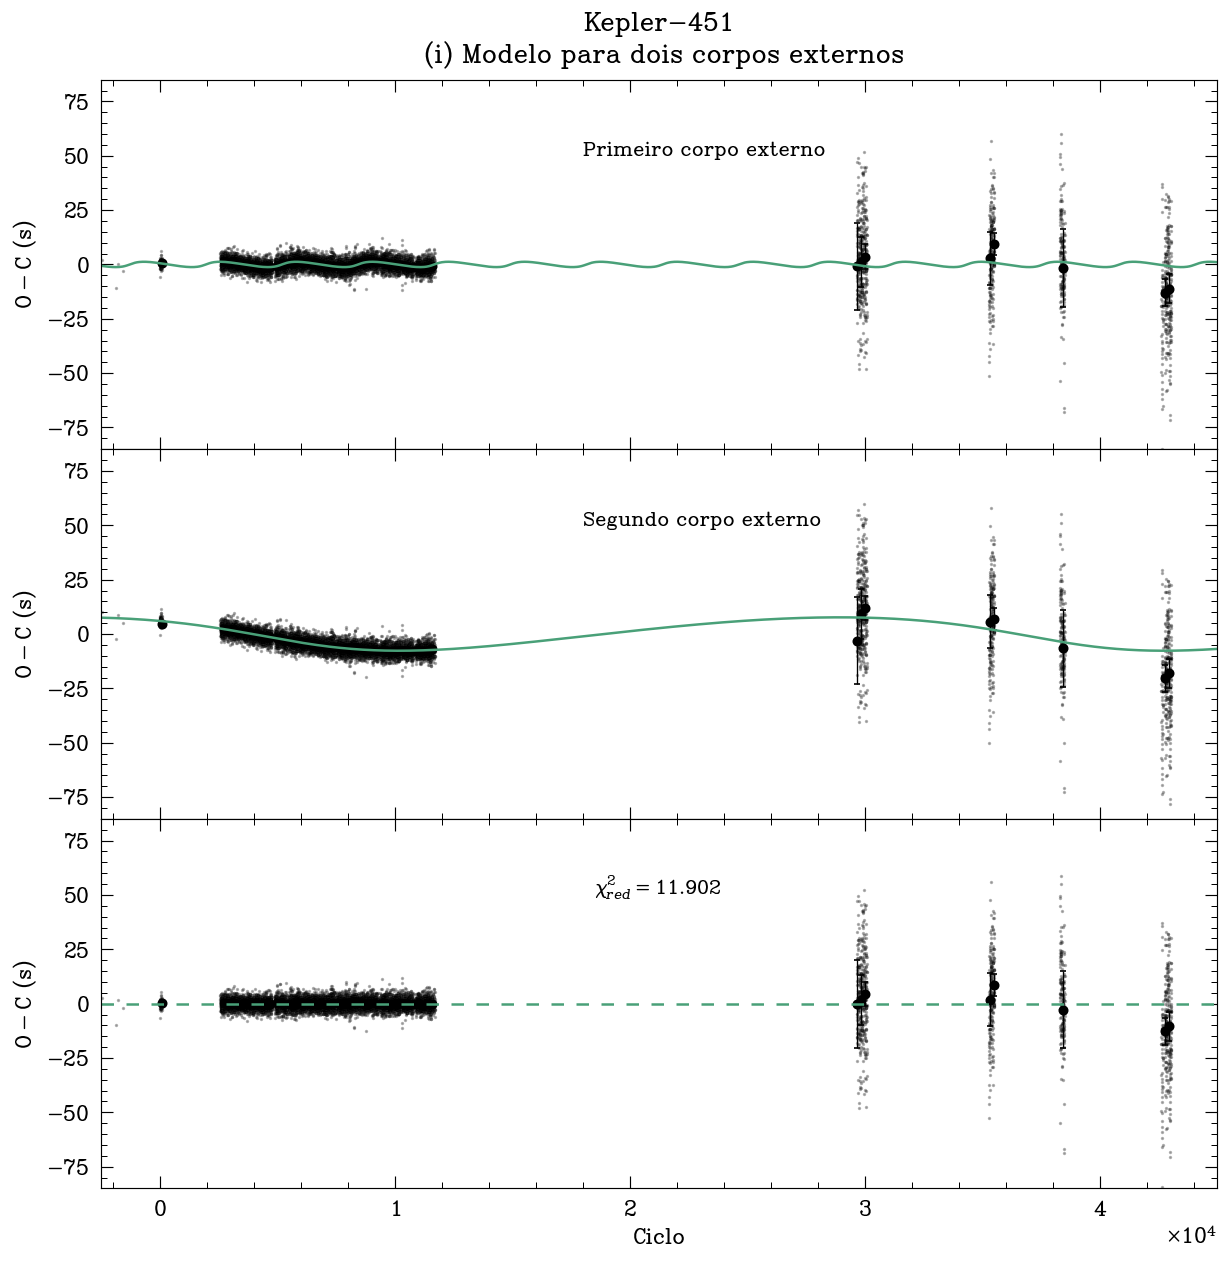

In [30]:
@jit(nopython=True)
def model_2bodys_mod (x, P, T0, P3, T3, e3, asini3, o3, P4, T4, e4, asini4, o4):
    
    n_points = len(x)

    efli = np.zeros(n_points)     
    tau3 = np.zeros(n_points)
    tau4 = np.zeros(n_points)

    r3   = 360./P3
    r4   = 360./P4

    for idx in range(n_points):
        n = x[idx]
        
        # Efeméride linear
        el = T0 + P*n
        efli[idx] = el
        
        # Primeiro corpo externo
        M  = ((T0 + P*n) - T3)*r3
        M1 = M -(360*int(M/360.))
        M2 = M1 * np.pi / 180.
        eps = M2 + e3*np.sin(M2)
        eps1 = eps + (M2 - (eps - e3*np.sin(eps)))/(1.0 - e3*np.cos(eps))
        for i in range(10):
            eps1 = eps1 + (M2 - (eps1 - e3*np.sin(eps1)))/(1.0 - e3*np.cos(eps1))
        q  = np.sqrt((1.0 + e3) / (1.0 - e3)) * np.tan(eps1 / 2.0)
        v  = 2. * np.arctan(q)
        aux1  = asini3*UA / (c*24*3600)
        aux2  = ((1. - e3**2) / (1 + e3*np.cos(v))) * np.sin(v + ((o3%360)*np.pi/180.))
        aux3  = e3*np.sin((o3%360)*np.pi/180.)
        mody  = aux1 * (aux2 + aux3)
        tau3[idx] = mody
        
        # Segundo corpo externo
        M  = ((T0 + P*n) - T4)*r4
        M1 = M -(360*int(M/360.))    
        M2 = M1 * np.pi / 180.
        eps = M2 + e4*np.sin(M2)     
        eps1 = eps + (M2 - (eps - e4*np.sin(eps)))/(1.0 - e4*np.cos(eps))
        for i in range(10):
            eps1 = eps1 + (M2 - (eps1 - e4*np.sin(eps1)))/(1.0 - e4*np.cos(eps1))
        q  = np.sqrt((1.0 + e4) / (1.0 - e4)) * np.tan(eps1 / 2.0)
        v  = 2. * np.arctan(q)       
        aux1  = asini4*UA / (c*24*3600)
        aux2  = ((1. - e4**2) / (1 + e4*np.cos(v))) * np.sin(v + ((o4%360)*np.pi/180.))
        aux3  = e4*np.sin((o4%360)*np.pi/180.)
        mody  = aux1 * (aux2 + aux3)
        tau4[idx] = mody
        
    return efli, tau3, tau4

results_2bodys = ascii.read('model_2bodys.dat')['valor']
P      = results_2bodys[0]
T0     = results_2bodys[1] 
P3     = results_2bodys[2] 
T3     = results_2bodys[3] 
e3     = results_2bodys[4] 
asini3 = results_2bodys[5]
o3     = results_2bodys[6] 
P4     = results_2bodys[7] 
T4     = results_2bodys[8]
e4     = results_2bodys[9] 
asini4 = results_2bodys[10]
o4     = results_2bodys[11]

efli, tau3, tau4 = model_2bodys_mod(x, P, T0, P3, T3, e3, asini3, o3, P4, T4, e4, asini4, o4)

x0 = np.linspace(-2500, 4.5e4, 1000)
eflic, tau3c, tau4c = model_2bodys_mod(x0, P, T0, P3, T3, e3, asini3, o3, P4, T4, e4, asini4, o4)

nbin = 65
xbin1, _, yerrbin1, ybin_efli = adaptative_bin(x, y, yerr, y - tau3 - tau4, nbin)
xbin2, _, yerrbin2, ybin_tau3 = adaptative_bin(x, y, yerr, y - efli - tau4, nbin)
xbin3, _, yerrbin3, ybin_tau4 = adaptative_bin(x, y, yerr, y - efli - tau3, nbin)
xbin4, _, yerrbin4, ybin_all  = adaptative_bin(x, y, yerr, y - efli - tau3 - tau4, nbin)


fig = plt.figure(figsize=(12,12))
fig.subplots_adjust(hspace=0)

ax1 = plt.subplot(311)
ax1.scatter(x, (y - efli - tau4)*24*3600, s=1, alpha=.3, c='grey')
ax1.errorbar(xbin2, (ybin_tau3)*24*3600, yerr=yerrbin2*24*3600, marker='o', ls='', capsize=2, c='k', lw=.8, ms=5, zorder=1)
ax1.plot(x0, (tau3c)*24*3600, c='#49a078', lw=1.5)
ax1.set_ylabel(r'$\rm O-C$ (s)')
ax1.set_xticklabels([])
ax1.set_xlim(-2500, 4.5e4)
ax1.set_ylim(-85, 85)
ax1.set_title('Kepler-451\n (i) Modelo para dois corpos externos')
ax1.annotate(text='Primeiro corpo externo', xy=(1.8e4, 50), fontsize=14)


ax2 = plt.subplot(312)
ax2.scatter(x, (y - efli - tau3)*24*3600, s=1, alpha=.3, c='grey')
ax2.errorbar(xbin3, (ybin_tau4)*24*3600, yerr=yerrbin3*24*3600, marker='o', ls='', capsize=2, c='k', lw=.8, ms=5, zorder=1)
ax2.plot(x0, (tau4c)*24*3600, c='#49a078', lw=1.5)
ax2.set_ylabel(r'$\rm O-C$ (s)')
ax2.set_xticklabels([])
ax2.set_xlim(-2500, 4.5e4)
ax2.set_ylim(-85, 85)
ax2.annotate(text='Segundo corpo externo', xy=(1.8e4, 50), fontsize=14)


ax3 = plt.subplot(313)
ax3.scatter(x, (y - efli - tau3 - tau4)*24*3600, s=1, alpha=.3, c='gray')
ax3.errorbar(xbin4, (ybin_all)*24*3600, yerr=yerrbin4*24*3600, marker='o', ls='', capsize=2, c='k', lw=.8, ms=5, zorder=1)
ax3.axhline(y=0.0, ls=(0,(5,5)),  c='#49a078', lw=1.5)
ax3.set_xlabel(r'Ciclo')
ax3.set_ylabel(r'$\rm O-C$ (s)')
ax3.set_xlim(-2500, 4.5e4)
ax3.set_ylim(-85, 85)
ax3.annotate(text=r'$\chi^{2}_{red} = $%.3f'%(reduced_chi2_2bodys(x, y, yerr, results_2bodys)), xy=(1.85e4, 50), fontsize=14)

#plt.savefig('O-C_2bodys.png')

Calculando as amplitudes dos sinais senoidais $\tau_3$ e $\tau_4$:

In [31]:
amplitude_tau3 = np.max(tau3) - np.min(tau3)
amplitude_tau4 = np.max(tau4) - np.min(tau4)

print(f'Amplitude da curva tau3: {amplitude_tau3*24*3600} s')
print(f'Amplitude da curva tau4: {amplitude_tau4*24*3600} s')

Amplitude da curva tau3: 2.454948286780674 s
Amplitude da curva tau4: 15.298208604683172 s


### Calculando as massas dos PCBs

Partindo da Terceira Lei de Kepler e do corolário do CM, determinamos as massas mínimas dos planetas, $M_j\sin{i_j}$², pela seguinte equação:

$$\frac{4\pi^2(a_j\sin i_j)^3}{GP'^2_j} = \frac{(M_j\sin i_j)^3}
 {(M+M_j)^2} ,$$
 
onde o subscrito $j$ refere-se às perturbações causadas na binária ($CM_2$) pelo j-ésimo corpo externo ($CM_j$) de massa $M_j$. Como a massa da binária é bem maior que a do PCB, $M >> M_j$, reescrevos a equação como:

$$\frac{4\pi^2(a_j\sin i_j)^3}{GP'^2_j} = \frac{(M_j\sin i_j)^3}
 {M^2}$$
 
²Ou, considerando os PCBs coplanares à binária, $M_j\sin{i}$, onde $i$ é a inclinação da binária encontrada por [Baran et al.](https://www.aanda.org/articles/aa/abs/2015/05/aa25392-14/aa25392-14.html).

In [32]:
#Massa projetada do primeiro planeta:

P3 = 407.46743581001
erro_P3 = (0.8571474790794014+0.8194174678782247)/2
asini3 = 0.002697200165670934
erro_asini3 = (3.735612342328472e-05+3.792964717874584e-05)/2

M3sini = ((asini3**3*(M_1+M_2)**2)/(P3/365.26)**2)**(1./3)
erro_M3sini = (((asini3+erro_asini3)**3*((M_1+erro_M1)+(M_2+erro_M2))**2)/((P3+erro_P3)/365.26)**2)**(1./3) - M3sini

#Massa projetada do segundo planeta:

P4 = 4098.452308684047
erro_P4 = (85.10803406339392+82.40548334652976)/2
asini4 = 0.015811659731699727
erro_asini4 = (0.0003111108593162777+0.0002942977737749111)/2

M4sini = ((asini4**3*(M_1+M_2)**2)/(P4/365.26)**2)**(1./3)
erro_M4sini = (((asini4+erro_asini4)**3*((M_1+erro_M1)+(M_2+erro_M2))**2)/((P4+erro_P4)/365.26)**2)**(1./3) - M3sini


print(f'Massa projetada do terceiro corpo: {M3sini*M_Sun/M_Jup} +/- {erro_M3sini*M_Sun/M_Jup}')
print(f'Massa projetada do quarto corpo: {M4sini*M_Sun/M_Jup} +/- {erro_M4sini*M_Sun/M_Jup}')

Massa projetada do terceiro corpo: 1.8693221313157797 +/- 0.10671070122996125
Massa projetada do quarto corpo: 2.351782259998977 +/- 0.5993385568788748


### Determinando o semieixo maior projetado das órbitas dos PCBs

Estimamos o semieixo maior projetado da órbita planetária a partir do $CM_2$ da binária da seguinte forma:

$$a_{M3} = \frac{Ma_3\sin i}{M_3\sin i}$$

In [36]:
#Semi-eixo maior projetado do primeiro corpo externo:

a_M3 = asini3*(M_1+M_2)/(M3sini)
erro_aM3 = (asini3+erro_asini3)*((M_1+erro_M1)+(M_2+erro_M2))/(M3sini) - a_M3


#Semi-eixo maior projetado do primeiro corpo externo:

a_M4 = asini4*(M_1+M_2)/(M4sini)
erro_aM4 = (asini4+erro_asini4)*((M_1+erro_M1)+(M_2+erro_M2))/(M3sini) - a_M3

print(f'Semi eixo maior projetado da órbita do terceiro corpo: {a_M3} +/- {erro_aM3}')
print(f'Semi eixo maior projetado da órbita do quarto corpo: {a_M4} +/- {erro_aM4}')

Semi eixo maior projetado da órbita do terceiro corpo: 0.907216508608423 +/- 0.07398656100361989
Semi eixo maior projetado da órbita do quarto corpo: 4.227292159810057 +/- 4.8742719257516205
